In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from scipy.signal import find_peaks
from functools import partial

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [6]:
def compute_average_waveform(files, bs_t_window=(-1.5e-5, -1.0e-5), threshold_bs=0.05):
    w = wfm2read(files[0], verbose=False)
    t, V = w[1], -w[0]

    V_avg = np.zeros_like(V)

    for f in files:
        t, V = load_waveform(f)

        # 1) Reject on "too large signal in baseline window"
        baseline_mask = (t > bs_t_window[0]) & (t < bs_t_window[1])
        V_w = V[baseline_mask]
        if (V_w > threshold_bs).sum() > 5:
            continue
        
        if V.shape != V_avg.shape:
            print(f'Warning: waveform in {f} has different shape. Skipping.')
            continue
        V_avg += V
    V_avg /= len(files)
    return V_avg, t

def compute_drift_time(t, V, height_S1=0.001):
    
    indS1 = find_peaks(V[t < 0], height=height_S1, distance=200)[0]

    if len(indS1) > 1:
        indS1 = indS1[np.argmax(V[indS1])]
    else:
        indS1 = indS1[0]

    indS2 = find_peaks(V[t > 0], height=V[indS1], distance=500)[0]

    if len(indS2) > 1:
        indS2 = indS2[np.argmin(t[indS2])]
    else:
        indS2 = indS2[0]
    indS2 += len(V[t < 0])
    return t[indS2] - t[indS1], indS1, indS2


def extract_voltage_pairs(base_dir, pattern=None):
    """Extract (anode_voltage, gate_voltage) pairs from subdirectory names."""
    voltage_pairs = []
    if pattern is None:
        pattern = 'FieldScan_1GSsec_Anode{}_Gate{}'
    subdirs = sorted(os.listdir(base_dir))
    for subdir in subdirs:
        try:
            gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
            anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
            # print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
            voltage_pairs.append((anode_voltage, gate_voltage))
        except AttributeError:
            continue
    return np.array(voltage_pairs)

In [ ]:
def compute_average_drift_time(subdir, batch_size=20, pattern='*.wfm'):
    allFiles = sorted(glob(subdir+pattern))
    files_batch = [sorted(glob(subdir+pattern))[batch_size*i:batch_size*(i+1)] for i in range(len(allFiles)//batch_size)]
    t_drifts = []
    t_s1s = []
    t_s2s = []
    duration_s2s = []
    for i,fi in enumerate(files_batch):
        v_avg, t_avg = compute_average_waveform(fi)
        try:
            v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
        except ValueError:
            continue
        try:
            tdrift, indS1, indS2 = compute_drift_time(t_avg, v_avg)
            dur_s2, _ = compute_s2_duration(t_avg, v_avg, indS1, indS2, frac_s1=0.8, min_distance=50, max_distance=4000)
        except IndexError:
            print(f'No S1 or S2 found in file set {i}')
            continue
        t_drifts.append(tdrift)
        t_s1s.append(t_avg[indS1])
        t_s2s.append(t_avg[indS2])
        duration_s2s.append(dur_s2)

    t_s1s = np.array(t_s1s) * 1e6
    t_s2s = np.array(t_s2s) * 1e6
    t_drift_avg = np.average(t_s2s) - np.average(t_s1s)
    t_drift_std = np.sqrt(np.std(t_s1s)**2 + np.std(t_s2s)**2)
    duration_avg = np.average(duration_s2s) * 1e6
    duration_std = np.std(duration_s2s) * 1e6
    return (t_drift_avg, t_drift_std), (duration_avg, duration_std), np.average(t_s1s), np.average(t_s2s)

def compute_s2_duration(t, V, indS1, indS2, frac_s1=0.8, min_distance=50, max_distance=4000):
    indS2_end = find_peaks(V[t > 0], height=V[indS1]*frac_s1, distance=min_distance)[0] + len(V[t < 0])
    indS2_end = indS2_end[np.where(np.diff(indS2_end) < max_distance)[0]]
    indS2_end = indS2_end[-1]
    tS2 = t[indS2_end] - t[indS2]
    return tS2, indS2_end

In [4]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec'
voltage_pairs = extract_voltage_pairs(base_dir, pattern='FieldScan_1GSsec_EL{}_Gate{}')
anode_voltages = voltage_pairs[:,0]
gate_voltages = voltage_pairs[:,1]
field_el = (anode_voltages - gate_voltages) / 0.8  # V/cm
field_drift = gate_voltages / 1.4  # V/cm
field_drift

array([ 35.71428571,  42.85714286,  50.        ,  57.14285714,
        64.28571429,  71.42857143, 107.14285714, 142.85714286,
       178.57142857, 214.28571429, 250.        , 285.71428571,
       321.42857143, 357.14285714, 428.57142857])

In [15]:
N=4.91e19  #cm-3
red_field_drift = field_drift/ N * 1e17 # Td
for f, rd in zip(field_drift, red_field_drift):
    print(f'{f:.2f} V/cm  -> {rd:.2f} Td')

35.71 V/cm  -> 0.07 Td
42.86 V/cm  -> 0.09 Td
50.00 V/cm  -> 0.10 Td
57.14 V/cm  -> 0.12 Td
64.29 V/cm  -> 0.13 Td
71.43 V/cm  -> 0.15 Td
107.14 V/cm  -> 0.22 Td
142.86 V/cm  -> 0.29 Td
178.57 V/cm  -> 0.36 Td
214.29 V/cm  -> 0.44 Td
250.00 V/cm  -> 0.51 Td
285.71 V/cm  -> 0.58 Td
321.43 V/cm  -> 0.65 Td
357.14 V/cm  -> 0.73 Td
428.57 V/cm  -> 0.87 Td


In [17]:
N=4.91e19  #cm-3 for 2.0 bar at 300 K
red_field_drift = field_drift/ N * 1e17 # Td
for f, rd in zip(field_drift, red_field_drift):
    print(f'{f:.2f} V/cm  -> {rd:.2f} Td')

35.71 V/cm  -> 0.07 Td
42.86 V/cm  -> 0.09 Td
50.00 V/cm  -> 0.10 Td
57.14 V/cm  -> 0.12 Td
64.29 V/cm  -> 0.13 Td
71.43 V/cm  -> 0.15 Td
107.14 V/cm  -> 0.22 Td
142.86 V/cm  -> 0.29 Td
178.57 V/cm  -> 0.36 Td
214.29 V/cm  -> 0.44 Td
250.00 V/cm  -> 0.51 Td
285.71 V/cm  -> 0.58 Td
321.43 V/cm  -> 0.65 Td
357.14 V/cm  -> 0.73 Td
428.57 V/cm  -> 0.87 Td


[Text(0.5, 0, 'Reduced field (Td)'), Text(0, 0.5, 'Drift velocity (mm/μs)')]

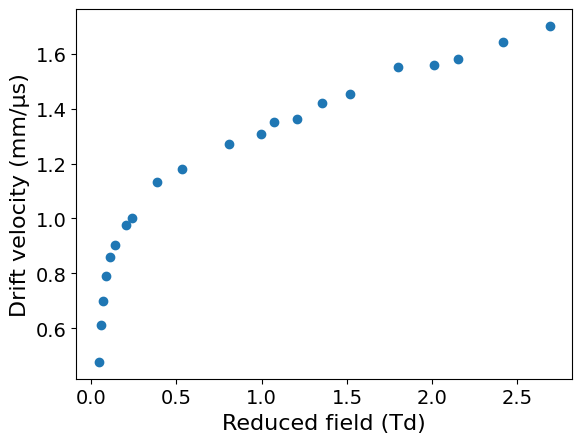

In [21]:
path_ds_graph = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/driftSpeed_redField_data.csv'
ds_graph = pd.read_csv(path_ds_graph, names=['reduced_field_Td', 'drift_velocity_mm_per_us'])
plt.plot(ds_graph['reduced_field_Td'], ds_graph['drift_velocity_mm_per_us'], 'o', label='Data from graph')
plt.gca().set(xlabel='Reduced field (Td)', ylabel='Drift velocity (mm/μs)')

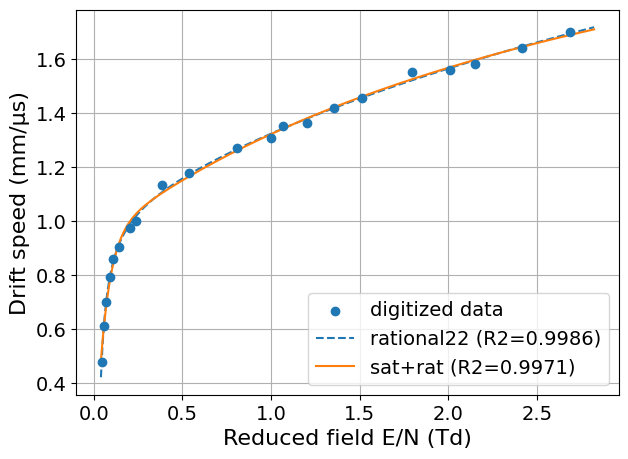

Rational 2/2 params: [ -49072.44485245 1983312.08224506 1003887.56018519 1905067.97109354
  315299.07743933]
Sat+Rational params: [ 0.92809704 17.17333489  0.51193002  0.30107278]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# --- Load your digitized data here (replace with your filename) ---
# Expect two columns: E (Td), v (mm/µs)
# data = np.loadtxt('digitized_points.csv', delimiter=',', skiprows=1)
# E = data[:,0]; v = data[:,1]

# for demo, replace with your actual digitized arrays:
E = ds_graph['reduced_field_Td'].to_numpy()  # Td (example)
v = ds_graph['drift_velocity_mm_per_us'].to_numpy() # mm/µs (example)

# --- Model 1: Rational 2/2 ---
def rational22(E, a0, a1, a2, b1, b2):
    return (a0 + a1*E + a2*E**2) / (1.0 + b1*E + b2*E**2)

p0_r22 = [0.0, 1.0, 0.0, 1.0, 0.1]   # initial guesses
bounds_r22 = ([-np.inf,-np.inf,-np.inf, 0.0, 0.0], np.inf)  # ensure denominator positive coefficients non-negative
popt_r22, pcov_r22 = curve_fit(rational22, E, v, p0=p0_r22, bounds=bounds_r22, maxfev=10000)
v_r22 = rational22(E, *popt_r22)
r2_r22 = r2_score(v, v_r22)

# --- Model 2: saturating + rational tail ---
def sat_plus_rational(E, p0, p1, p2, p3):
    return p0*(1.0 - np.exp(-p1*E)) + (p2*E) / (1.0 + p3*E)

# popt_s = [ 0.92809704, 17.17333489,  0.51193002,  0.30107278]
p0_s = [1.0, 3.0, 0.5, 1.0]
bounds_s = (0.0, np.inf)  # all positive params
popt_s, pcov_s = curve_fit(sat_plus_rational, E, v, p0=p0_s, bounds=bounds_s, maxfev=10000)
v_s = sat_plus_rational(E, *popt_s)
r2_s = r2_score(v, v_s)

# --- Plot ---
E_plot = np.linspace(min(E)*0.9, max(E)*1.05, 300)
plt.figure(figsize=(7,5))
plt.scatter(E, v, label='digitized data', zorder=5)
plt.plot(E_plot, rational22(E_plot, *popt_r22), '--', label=f'rational22 (R2={r2_r22:.4f})')
plt.plot(E_plot, sat_plus_rational(E_plot, *popt_s), '-', label=f'sat+rat (R2={r2_s:.4f})')
plt.xlabel('Reduced field E/N (Td)')
plt.ylabel('Drift speed (mm/µs)')
plt.legend()
plt.grid(True)
plt.show()

# --- Print parameters ---
print("Rational 2/2 params:", popt_r22)
print("Sat+Rational params:", popt_s)


In [978]:
field2drift(field_drift[0]), field_drift[0], red_field_drift[0]

(2.483771198160392, 35.714285714285715, 0.07273785277858598)

In [53]:
def transport_saturation(E, p0, p1, p2, p3):
    return p0*(1.0 - np.exp(-p1*E)) + (p2*E) / (1.0 + p3*E)

popt_s = [ 0.92809704, 17.17333489,  0.51193002,  0.30107278]
field2drift = lambda E: transport_saturation(E, *popt_s)
drift_speeds = np.array([field2drift(Ei) for Ei in red_field_drift])
drift_times = 14 / drift_speeds  # µs

print(f'{"Red field (Td)":>15}, {"Drift speed (mm/µs)":>20}, {"Drift time (µs)":>15}')
for rf, ds, dt in zip(red_field_drift, drift_speeds, drift_times):
    print(f'{rf:15.2f}, {ds:20.4f}, {dt:15.4f}')

 Red field (Td),  Drift speed (mm/µs), Drift time (µs)
           0.07,               0.6984,         20.0457
           0.09,               0.7643,         18.3165
           0.10,               0.8172,         17.1315
           0.12,               0.8599,         16.2813
           0.13,               0.8946,         15.6493
           0.15,               0.9231,         15.1657
           0.22,               1.0110,         13.8472
           0.29,               1.0588,         13.2229
           0.36,               1.0941,         12.7958
           0.44,               1.1251,         12.4438
           0.51,               1.1540,         12.1321
           0.58,               1.1815,         11.8490
           0.65,               1.2080,         11.5890
           0.73,               1.2336,         11.3492
           0.87,               1.2819,         10.9209


In [ ]:
field_drift[2], red_field_drift[2], drift_speeds[2], drift_times[2]
print(f'Gate voltage: {gate_voltages[2]:.2f} V')
print(f'Field drift: {field_drift[2]:.2f} V/cm, Reduced field: {red_field_drift[2]:.2f} Td')
print(f'Drift speed: {drift_speeds[2]:.2f} mm/μs, Drift time: {drift_times[2]:.2f} μs')

Gate voltage: 70.00 V
Field drift: 50.00 V/cm, Reduced field: 0.10 Td
Drift speed: 0.82 mm/μs, Drift time: 17.13 μs


# Waveform rejection

In [281]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec'
voltage_pairs = extract_voltage_pairs(base_dir, pattern='FieldScan_1GSsec_EL{}_Gate{}')
anode_voltages = voltage_pairs[:,0]
gate_voltages = voltage_pairs[:,1]
field_el = (anode_voltages - gate_voltages) / 0.8  # V/cm
field_drift = gate_voltages / 1.4  # V/cm
field_drift, red_field_drift

(array([ 35.71428571,  42.85714286,  50.        ,  57.14285714,
         64.28571429,  71.42857143, 107.14285714, 142.85714286,
        178.57142857, 214.28571429, 250.        , 285.71428571,
        321.42857143, 357.14285714, 428.57142857]),
 array([0.07273785, 0.08728542, 0.10183299, 0.11638056, 0.13092814,
        0.14547571, 0.21821356, 0.29095141, 0.36368926, 0.43642712,
        0.50916497, 0.58190282, 0.65464068, 0.72737853, 0.87285423]))

In [283]:
field_drift[2], red_field_drift[2]

(50.0, 0.10183299389002036)

In [63]:
subdirs = sorted(glob(base_dir+'/FieldScan*'))
files05 = sorted(glob(base_dir+'/FieldScan_1GSsec_EL2470_Gate70/*.wfm'))
files05[:10], subdirs[2]

(['/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0000.wfm',
  '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0001.wfm',
  '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0002.wfm',
  '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0003.wfm',
  '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0004.wfm',
  '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/FieldScan_1GSsec_EL2470_Gate70/RUN2_21082025_Gate70_Anode2470_P3_0005.wfm',
  '/Users/pabloherrero/sabat

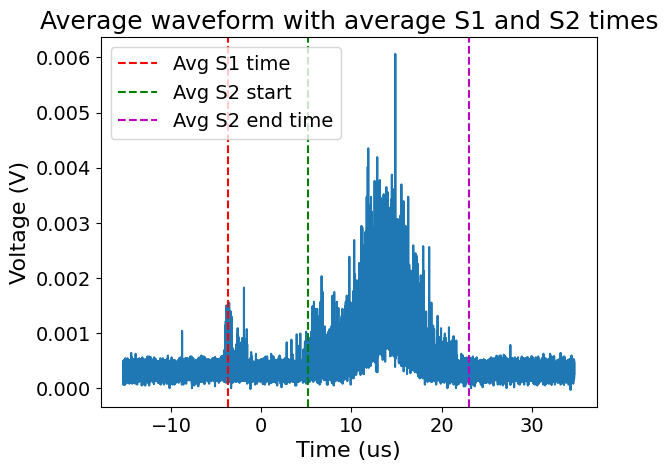

In [75]:
win = S2Window(subdirs[2], batch_size=50)
win.compute_average_s2_window()
win.plot_avg_values()

In [160]:
i = 1

In [819]:
win.s1_avg, win.s1_avg * 0.9

(-3.7472413793103433e-06, -3.372517241379309e-06)

In [949]:
drift_window[0]

-3.6972413793103436

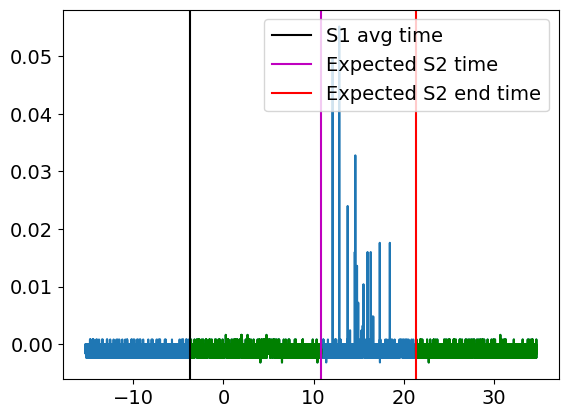

In [957]:
s1_jitter = 0.05 # μs
s2_tol_start = 2.5 # μs
s2_duration = 8 # μs
s2_tol_end = 2.5 # μs
# s2_tol_end = 10e-6
drift_window = (win.s1_avg * 1e6 + s1_jitter, win.s1_avg *1e6 - s1_jitter + drift_times[2] - s2_tol_start)
s2_window = (drift_window[1], drift_window[1] + s2_duration + s2_tol_end)


i += 1
file = files05[i]
t, V = load_waveform(file)
t *= 1e6  # to μs

Vdrift = V[(t > drift_window[0]) & (t < drift_window[1])]
tdrift = t[(t > drift_window[0]) & (t < drift_window[1])]
plt.plot(t, V)
thresh = Vdrift > 0.02
clean_drift = len(thresh[thresh > 0]) < 3

if clean_drift:
    plt.plot(tdrift, Vdrift, 'g')
else:
    plt.plot(tdrift, Vdrift, 'r')

Vpost = V[t > s2_window[1]]
tpost = t[t > s2_window[1]]
clean_post = len(Vpost[Vpost > 0.02]) < 3
if clean_post:
    plt.plot(tpost, Vpost, 'g')
else:
    plt.plot(tpost, Vpost, 'r')

plt.axvline(drift_window[0] ,color='k', label='S1 avg time')
plt.axvline(drift_window[1], color='m', label='Expected S2 time')
plt.axvline(s2_window[1], color='r', label='Expected S2 end time')
# plt.axvline(win.s1_avg *1e6,color='orange', label='S1 avg time')
# plt.axvline(win.s1_avg* 1e6 + drift_times[2] - 2.5, color='g', lw=2, label='Expected S2 time')
# plt.axvline(win.s1_avg* 1e6+ drift_times[2] -2.5 + 10. , color='k', lw=2, label='Expected S2 end time')
plt.legend()

In [354]:
diff_coeff = 130  # cm2/s
diff_length = np.sqrt(130 * 17e-6) # cm
diff_length
first_electron_pass = - 3 * diff_length / drift_times[2]
last_electron = 6 * diff_length / drift_times[2]
last_electron - first_electron_pass

0.024696910021014512

In [284]:
drift_speeds[2]

0.8172068698257858

In [ ]:
drift_times[2]*0.9

17.13152509716977

# Rewrite Analysis classes

In [888]:
win.s1_avg, s2_tol_start

(-3.7472413793103433e-06, 2.5)

In [979]:

class S2AreaExtractor:
    """Class to extract S2 areas from waveform files.
    1) Reject on "too large signal in baseline window"
    2) Baseline-subtract
    3) Integrate S2
    """
    def __init__(self, files, threshold_bs=0.05, s2_start=1e-6, s2_duration=2e-5, bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None):
        """Initialize with waveform files and parameters.
        Args:
            files (list): List of waveform file paths.
            s2_start (float): Time start of S2 window.
            s2_duration (float): Duration of S2 window. (Fixed for a Field Scan)
            threshold_bs (float): Threshold for baseline rejection.
            bs_t_window (tuple): Time window for baseline subtraction.
            bs_v_window (tuple): Voltage window for baseline subtraction.
        """
        self.files = files
        self.s2_start = s2_start
        self.s2_duration = s2_duration
        self.threshold_bs = threshold_bs
        self.bs_t_window = bs_t_window
        self.bs_v_window = bs_v_window

    def baseline_rejection(self, t, V):
        """Reject waveform based on baseline window criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        baseline_mask = (t > self.bs_t_window[0]) & (t < self.bs_t_window[1])
        V_w = V[baseline_mask]
        return (V_w > self.threshold_bs).sum() <= 5
    
    def drift_distance_rejection(self, t, V):
        """Reject waveform based on drift distance criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        Vdrift = V[(t > drift_window[0]) & (t < drift_window[1])]
        return len(Vdrift[Vdrift > 0.02]) < 3
    
    def post_s2_rejection(self, t, V):
        """Reject waveform based on post-S2 signal criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        Vpost = V[t > self.s2_start + self.s2_duration]
        return len(Vpost[Vpost > 0.02]) < 3

    def extract_areas(self):
        """Extract S2 areas from waveform files.
        Returns:
            np.array: Array of extracted S2 areas.
        """
        areas = []
        self.bs_rejected = 0
        self.drift_rejected = 0
        self.post_s2_rejected = 0

        for f in self.files:
            t, V = load_waveform(f)

            # 1) Rejections 
            if not self.baseline_rejection(t, V):
                self.bs_rejected += 1
                continue
            if not self.drift_distance_rejection(t, V):
                self.drift_rejected += 1
                continue
            if not self.post_s2_rejection(t, V):
                self.post_s2_rejected += 1
                continue

            # 2) Baseline-subtract
            V_corr = subtract_baseline(t, V, self.bs_t_window, self.bs_v_window)

            # 4) Integrate S2
            area = integrate_s2(t, V_corr, self.s2_start, self.s2_start + self.s2_duration)
            areas.append(area)

        return np.array(areas)

class FieldScanAnalyzer:
    """Class to analyze field scan data.
    1) Extract voltage pairs from subdirectory names.
    2) Calculate electric fields from voltage pairs and gaps.
    3) Check if E_el is constant and if E_el/E_drift > 2.
    4) Extract S2 areas from waveform files.
    5) Apply histogram cuts.
    6) Plot histograms.
    """
    def __init__(self, base_dir, pattern=None, to_drop = None, n_files=None,
                areaExtractor=S2AreaExtractor, fitter=GaussianFitter,
                s1_time=-3.74, s2_tol_start=2.5, N_density=4.91e19,
                hist_cuts=(-5, 120), nbins=120, EL_gap=0.8, drift_gap=1.4):
        """Initialize with base directory and parameters.
        Args:
            base_dir (str): Base directory containing field scan subdirectories.
            pattern (str): Pattern for subdirectory names.
            areaExtractor (class): Class to extract S2 areas from waveform files.
            hist_cuts (tuple): Histogram cuts for S2 areas.
            nbins (int): Number of bins for histograms.
            EL_gap (float): Gap distance for EL field calculation.
            drift_gap (float): Gap distance for drift field calculation.
        """
        self.base_dir = base_dir
        self.pattern = pattern
        self.to_drop = to_drop 
        self.n_files = n_files

        self.hist_cuts = hist_cuts
        self.nbins = nbins
        
        self.areaExtractor = areaExtractor
        self.fitter = fitter

        self.s1_time = s1_time
        self.s2_tol_start = s2_tol_start 
        self.EL_gap = EL_gap # cm
        self.drift_gap = drift_gap # cm
        self.N_density = N_density  #cm-3 for 2.0 bar at 300 K
        self.setup()


    def setup(self):
        """Setup by extracting voltage pairs and calculating fields."""
        self.voltage_pairs = extract_voltage_pairs(self.base_dir, self.pattern)
        if self.to_drop is not None:
            self.voltage_pairs = drop_voltage_pairs(self.voltage_pairs, to_drop=self.to_drop)
            
        self.v_gate = self.voltage_pairs[:, 1]
        self.v_anode = self.voltage_pairs[:, 0]
        self.E_drift, self.E_el = get_fields(self.voltage_pairs, self.EL_gap, self.drift_gap)
        self.E_dr_dict, self.E_el_dict = dict(zip(self.v_gate, self.E_drift)), dict(zip(self.v_gate, self.E_el))
        self.voltage_over_lim = check_fields(self.voltage_pairs, self.E_el, self.E_drift)

    def estimate_drift_time(self, drift_field):
        """Find expected S2 start time from the drift velocity."""
        red_field_drift = drift_field/ self.N_density * 1e17 # Td
        drift_speed = field2drift(red_field_drift)  # mm/μs
        print(f'Estimated drift speed = {drift_speed} mm/μs for drift field {drift_field} V/cm')
        drift_gap_mm = self.drift_gap * 10  # cm to mm
        drift_time = drift_gap_mm / drift_speed  # μs
        s2_start = self.s1_time + drift_time - self.s2_tol_start  # μs
        return s2_start / 1e6, drift_time  # to seconds

    def analyze(self):
        """Analyze field scan data and plot histograms."""
        hist_lowcut, hist_upcut = self.hist_cuts

        s2_areas = {}
        s2_areas_cuts = {}
        glob_pattern = self.pattern + '/*.wfm' if self.pattern else 'FieldScan_1GSsec_EL{}_Gate{}' + '/*.wfm'
        for anode_v, gate_v in self.voltage_pairs:
            path = os.path.join(self.base_dir, glob_pattern.format(anode_v, gate_v))
            files = sorted(glob(path))
            if self.n_files is not None:
                files = files[:self.n_files]
            print(f'Integrating {len(files)} files for EL {anode_v} V, Gate {gate_v} V')
            print(f'Field drift: {self.E_dr_dict[gate_v]:.2f} V/cm, Field EL: {self.E_el_dict[gate_v]:.2f} V/cm')

            s2_start, drift_t = self.estimate_drift_time(self.E_dr_dict[gate_v])
            print(f'Found S2 start at {s2_start:.4e} us and drift time {drift_t:.4e} us for EL {anode_v} V, Gate {gate_v} V')
            
            extractor = self.areaExtractor(files, s2_start=s2_start)
            arr_areas = extractor.extract_areas()
            s2_areas[gate_v] = arr_areas
            s2_areas_cuts[gate_v] = apply_hist_cuts(arr_areas, hist_lowcut, hist_upcut)
            area_out_path = os.path.join(self.base_dir, self.pattern.format(anode_v, gate_v), f'area_s2_EL{anode_v}_Gate{gate_v}.npy')
            save_area_array(arr_areas, area_out_path)
        self.s2_areas = s2_areas
        self.s2_areas_cuts = s2_areas_cuts
        return s2_areas_cuts, s2_areas
    
    def plot_histograms(self, ax = None, label_anode = False, label_gate = False):
        """Plot histograms of S2 areas for all voltage pairs."""
        if ax is None:
            ax = plt.gca()
        for (anode_v, gate_v) in self.voltage_pairs:
            label = f"$E_{{drift}}$: {round(gate_v/self.drift_gap)} V/cm"
            if label_anode: label += " $V_{{anode}}$: {anode_v} V"
            if label_gate: label += " $V_{{gate}}$: {gate_v} V"
            ax.hist(self.s2_areas_cuts[gate_v], bins=self.nbins, alpha=0.5, label=label)
        ax.set(xlabel = 'S2 Area (mV*us)', ylabel = 'Counts', title = f'Drift field scan, EL field: {self.E_el[0]} kV/cm')

        plt.legend(fontsize=10)
        return ax
    
    def fit_histograms_2peaks(self, nbins=100, sep_A = 70, flag_plot:bool = True, ax=None):
        """Fit Gaussian to histograms of S2 areas for all voltage pairs."""
         
        mask_range_p1=(self.hist_cuts[0], sep_A)
        mask_range_p2=(sep_A, self.hist_cuts[1])
        if ax is None:
            ax = plt.gca()
        fit_results_p1 = {}
        fit_results_p2 = {}
        for gate_v, a1 in self.s2_areas_cuts.items():
            n, bins = np.histogram(a1, bins=nbins)
            fitter_p1 = self.fitter(n, bins, label=str(gate_v), mask_range=mask_range_p1)
            fitter_p2 = self.fitter(n, bins, label=str(gate_v), mask_range=mask_range_p2)
            try:
                fitter_p1.fit()
                fitter_p2.fit()
            except (ValueError, RuntimeError):
                print(f"Could not fit Gaussian for gate voltage {gate_v} V")
                continue
            if flag_plot:
                fitter_p1.plot(ax=ax)
                fitter_p2.plot(ax=ax, flag_label=False)
            mean_p1, ci95_p1 = fitter_p1.get_fit_params()
            mean_p2, ci95_p2 = fitter_p2.get_fit_params()
            fit_results_p1[gate_v] = (mean_p1, ci95_p1)
            fit_results_p2[gate_v] = (mean_p2, ci95_p2)
            print(f'{gate_v} V: amplitude={fitter_p1.popt[0]:.2f}, mean={fitter_p1.popt[1]:.2f}, sigma={fitter_p1.popt[2]:.2f})')
            print(f'{gate_v} V: amplitude={fitter_p2.popt[0]:.2f}, mean={fitter_p2.popt[1]:.2f}, sigma={fitter_p2.popt[2]:.2f})')
        self.fit_results_p1 = fit_results_p1
        self.fit_results_p2 = fit_results_p2
        return fit_results_p1, fit_results_p2
    
    def plot_s2_vs_field(self):

        """Plot fit results of Gaussian fits to histograms of S2 areas."""
        fig, ax = plt.subplots(2, figsize=(8, 10), sharex=True)
            
        mean_p1, ci95_p1 = zip(*self.fit_results_p1.values())
        mean_p2, ci95_p2 = zip(*self.fit_results_p2.values())
        E_d = [self.E_dr_dict[v] for v in self.fit_results_p1.keys()]
        ax[0].errorbar(E_d, mean_p1, yerr=ci95_p1, fmt='o', color='blue', capsize=10, capthick=2, label='High S2 area peak')
        ax[1].errorbar(E_d, mean_p2, yerr=ci95_p2, fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')

        for a in ax:
            a.legend()
            a.set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
                title='Mean S2 Area vs $E_{drift}$ (95% CI)')
        return ax



## Test on RUN2 data

In [958]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN2_EL3kVcm_1GSsec'
pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
fitter = GaussianFitter

area_extractor = partial(
    S2AreaExtractor,
    threshold_bs=0.07,
    s2_duration=10e-6,
    bs_t_window=(-1.5e-5, -1.0e-5),
    bs_v_window=(-0.005, 0.005)
)

In [980]:
analyzer = FieldScanAnalyzer(
    base_dir,
    n_files=3000,
    pattern=pattern,
    areaExtractor=area_extractor,
    fitter=GaussianFitter,
    s1_time=-3.74,
    s2_tol_start=2.5,
    hist_cuts=(-5, 120),
    nbins=120,
    EL_gap=0.8,
    drift_gap=1.4
)

In [968]:
drift_times

array([20.0456532 , 18.31646871, 17.1315251 , 16.28126727, 15.64926045,
       15.16574186, 13.84715472, 13.22285867, 12.79582735, 12.44384681,
       12.13214152, 11.84895362, 11.58904045, 11.34922648, 10.92088295])

In [975]:
field2drift(field_drift[0])

2.483771198160392

In [963]:
field_drift

array([ 35.71428571,  42.85714286,  50.        ,  57.14285714,
        64.28571429,  71.42857143, 107.14285714, 142.85714286,
       178.57142857, 214.28571429, 250.        , 285.71428571,
       321.42857143, 357.14285714, 428.57142857])

In [971]:
drift_speeds

array([0.69840578, 0.76433947, 0.81720687, 0.85988392, 0.89461097,
       0.92313321, 1.01103803, 1.05877257, 1.09410667, 1.12505403,
       1.1539595 , 1.18153893, 1.20803789, 1.23356425, 1.28194763])

In [964]:
win.s1_avg * 1e6 + drift_times[0]

16.298411822615886

In [999]:
_, x = load_waveform(files05[0])
len(x)

50000

In [981]:
analyzer.analyze()

Integrating 3000 files for EL 2450 V, Gate 50 V
Field drift: 35.71 V/cm, Field EL: 3000.00 V/cm
Estimated drift speed = 0.6984028322327005 mm/μs for drift field 35.714 V/cm
Found S2 start at 1.3806e-05 us and drift time 2.0046e+01 us for EL 2450 V, Gate 50 V
Integrating 3000 files for EL 2460 V, Gate 60 V
Field drift: 42.86 V/cm, Field EL: 3000.00 V/cm
Estimated drift speed = 0.7643382937454182 mm/μs for drift field 42.857 V/cm
Found S2 start at 1.2076e-05 us and drift time 1.8316e+01 us for EL 2460 V, Gate 60 V
Integrating 3000 files for EL 2470 V, Gate 70 V
Field drift: 50.00 V/cm, Field EL: 3000.00 V/cm
Estimated drift speed = 0.8172068698257858 mm/μs for drift field 50.0 V/cm
Found S2 start at 1.0892e-05 us and drift time 1.7132e+01 us for EL 2470 V, Gate 70 V
Integrating 3000 files for EL 2480 V, Gate 80 V
Field drift: 57.14 V/cm, Field EL: 3000.00 V/cm
Estimated drift speed = 0.859884692295346 mm/μs for drift field 57.143 V/cm
Found S2 start at 1.0041e-05 us and drift time 1.6281

({50: array([24.09840171, 15.43960109, 23.19600164, 15.6108011 , 15.77200112,
         23.34720165, 15.97480113, 15.92080113, 15.72560111, 15.70720111,
         15.10440107, 16.35720116, 15.79760112, 15.45960109, 16.10680114,
         15.11640107, 22.97000163, 14.50320103, 15.88320112, 15.43000109,
         16.02720113, 16.14440114, 15.28280108, 15.18360107, 24.97360177,
         16.02760113, 23.47280166, 14.90160105, 15.33760109, 23.64840167,
         25.54960181, 15.36000109, 15.32640108, 15.63320111, 15.40520109,
         15.93760113, 23.92920169, 22.6096016 , 14.78120105, 23.56960167,
         16.07680114, 15.94400113, 15.93480113, 22.98480163, 14.98200106,
         16.66760118, 14.33640101, 14.34960102, 23.77080168, 16.46680117,
         16.8880012 , 23.90320169, 16.18600115, 14.82640105, 15.95320113,
         14.90280105, 16.56200117, 14.96800106, 15.5604011 , 17.43280123,
         25.08200178, 15.72720111, 15.5308011 , 24.0840017 , 15.04160106,
         15.79080112, 16.54760117,

<Axes: title={'center': 'Drift field scan, EL field: 3000.0 kV/cm'}, xlabel='S2 Area (mV*us)', ylabel='Counts'>

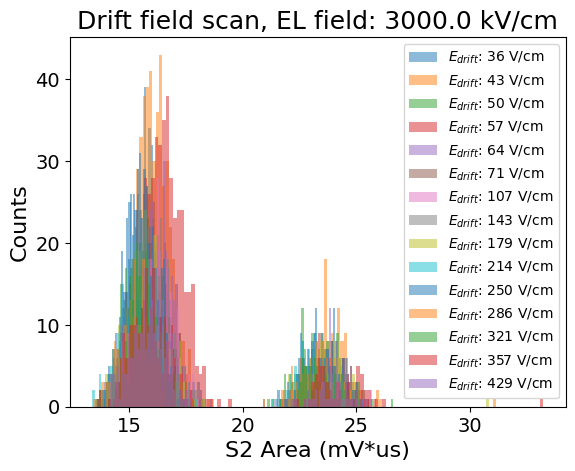

In [994]:
analyzer.plot_histograms()

50 V: amplitude=35.05, mean=15.72, sigma=0.70)
50 V: amplitude=9.04, mean=23.54, sigma=0.82)
60 V: amplitude=47.34, mean=16.04, sigma=0.73)
60 V: amplitude=12.80, mean=23.85, sigma=0.65)
70 V: amplitude=24.09, mean=15.76, sigma=0.90)
70 V: amplitude=7.83, mean=23.23, sigma=0.91)
80 V: amplitude=40.70, mean=16.49, sigma=0.84)
80 V: amplitude=5.42, mean=24.22, sigma=0.90)
90 V: amplitude=25.16, mean=16.17, sigma=0.77)
90 V: amplitude=5.82, mean=23.94, sigma=0.65)
100 V: amplitude=21.94, mean=15.75, sigma=0.82)
100 V: amplitude=6.41, mean=23.54, sigma=0.78)
150 V: amplitude=21.52, mean=16.07, sigma=0.78)
150 V: amplitude=5.60, mean=23.74, sigma=0.75)
200 V: amplitude=20.40, mean=15.99, sigma=0.75)
200 V: amplitude=5.55, mean=23.48, sigma=0.64)
250 V: amplitude=22.50, mean=15.62, sigma=0.79)
250 V: amplitude=7.97, mean=23.47, sigma=0.85)
300 V: amplitude=14.27, mean=15.32, sigma=0.82)
300 V: amplitude=6.83, mean=22.96, sigma=0.67)
350 V: amplitude=31.23, mean=15.54, sigma=0.74)
350 V: ampl

({50: (15.719792674139967, 0.05926098603010573),
  60: (16.03952393713772, 0.04698241868200043),
  70: (15.762645313547914, 0.07647380531128606),
  80: (16.494904481609865, 0.07481947685504862),
  90: (16.172198752636522, 0.08892326356337828),
  100: (15.752884598519477, 0.07858164462137754),
  150: (16.07030339456521, 0.0783892127264222),
  200: (15.989088858630348, 0.06897408456561452),
  250: (15.6220876863003, 0.07800245508510978),
  300: (15.31556144394387, 0.08604475075085387),
  350: (15.537956546101112, 0.047979864936168674),
  400: (15.303173813530371, 0.07022060273356194),
  450: (15.62204201376408, 0.07756584408060523),
  500: (15.784245512428326, 0.09274048227199769),
  600: (15.849061176822262, 0.11103098677455835)},
 {50: (23.539778203310124, 0.16026861441554033),
  60: (23.853840651477523, 0.07156403881677773),
  70: (23.229305603531888, 0.1582051990015654),
  80: (24.223269467667524, 0.16681363894035095),
  90: (23.93962400957303, 0.16193732111673537),
  100: (23.535914

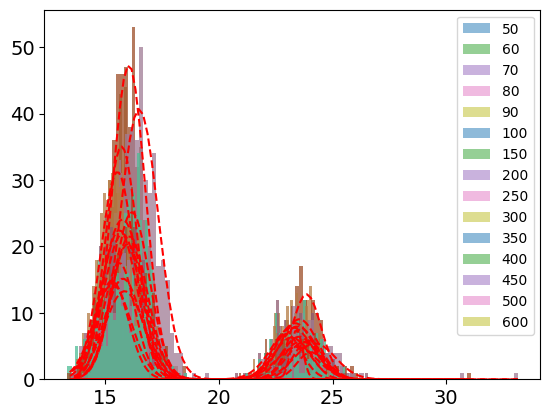

In [985]:
analyzer.fit_histograms_2peaks(sep_A=20)

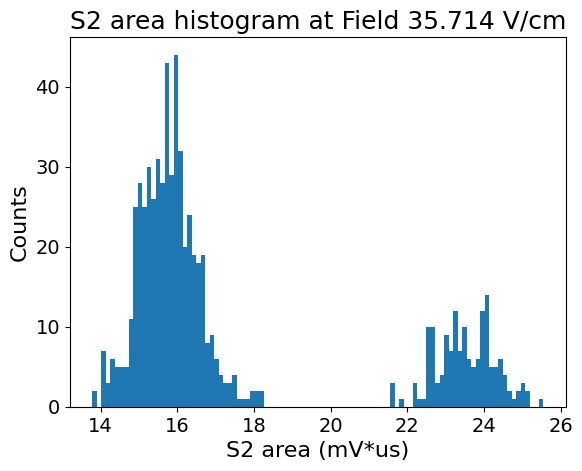

In [993]:
areas_50 = analyzer.s2_areas_cuts[50]
plt.hist(areas_50, bins=100);
plt.gca().set(xlabel='S2 area (mV*us)', ylabel='Counts', title='S2 area histogram at Field {} V/cm'.format(analyzer.E_dr_dict[50]));

array([<Axes: title={'center': 'Mean S2 Area vs $E_{drift}$ (95% CI)'}, xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\\cdot$us)'>,
       <Axes: title={'center': 'Mean S2 Area vs $E_{drift}$ (95% CI)'}, xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\\cdot$us)'>],
      dtype=object)

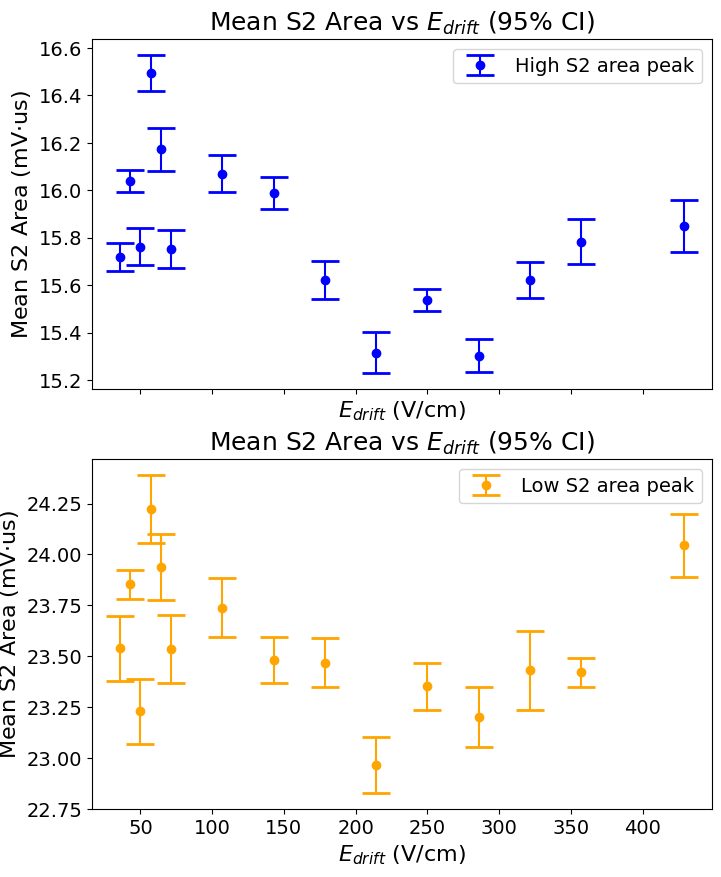

In [986]:
analyzer.plot_s2_vs_field()

<Axes: title={'center': 'Drift field scan, EL field: 3000.0 kV/cm'}, xlabel='S2 Area (mV*us)', ylabel='Counts'>

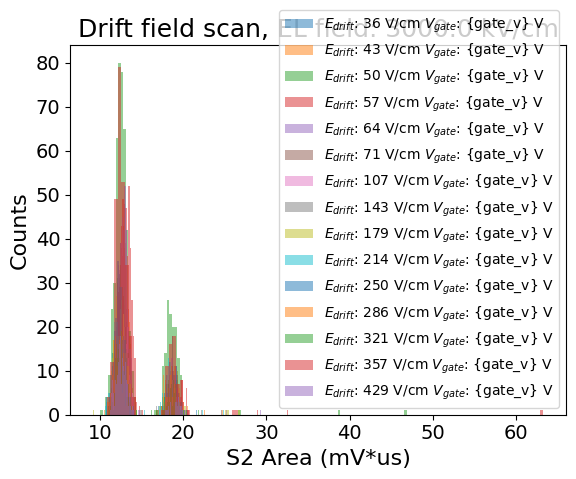

In [ ]:
analyzer.plot_histograms(label_gate=True)

# Load RUN1 data

In [9]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/'
# sbd = ['FieldScan_1GSsec_EL1450_Gate50', 'FieldScan_1GSsec_EL1650_Gate250', 'FieldScan_1GSsec_EL2000_Gate600', 'FieldScan_1GSsec_EL3600_Gate2200']
pattern = '/*.wfm'
# subdirs = [f'{base_dir}{d}/' for d in sbd]
subdirs = sorted(glob(f'{base_dir}FieldScan_1GSsec_EL*'))
subdirs

['/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1450_Gate50',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1460_Gate60',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1465_Gate65',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1470_Gate70',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1475_Gate75',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1500_Gate100',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1550_Gate150',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1650_Gate250',
 '/Users/pabloherrero/sabat/RaTagging

No S1 or S2 found in file set 2
No S1 or S2 found in file set 10
No S1 or S2 found in file set 19


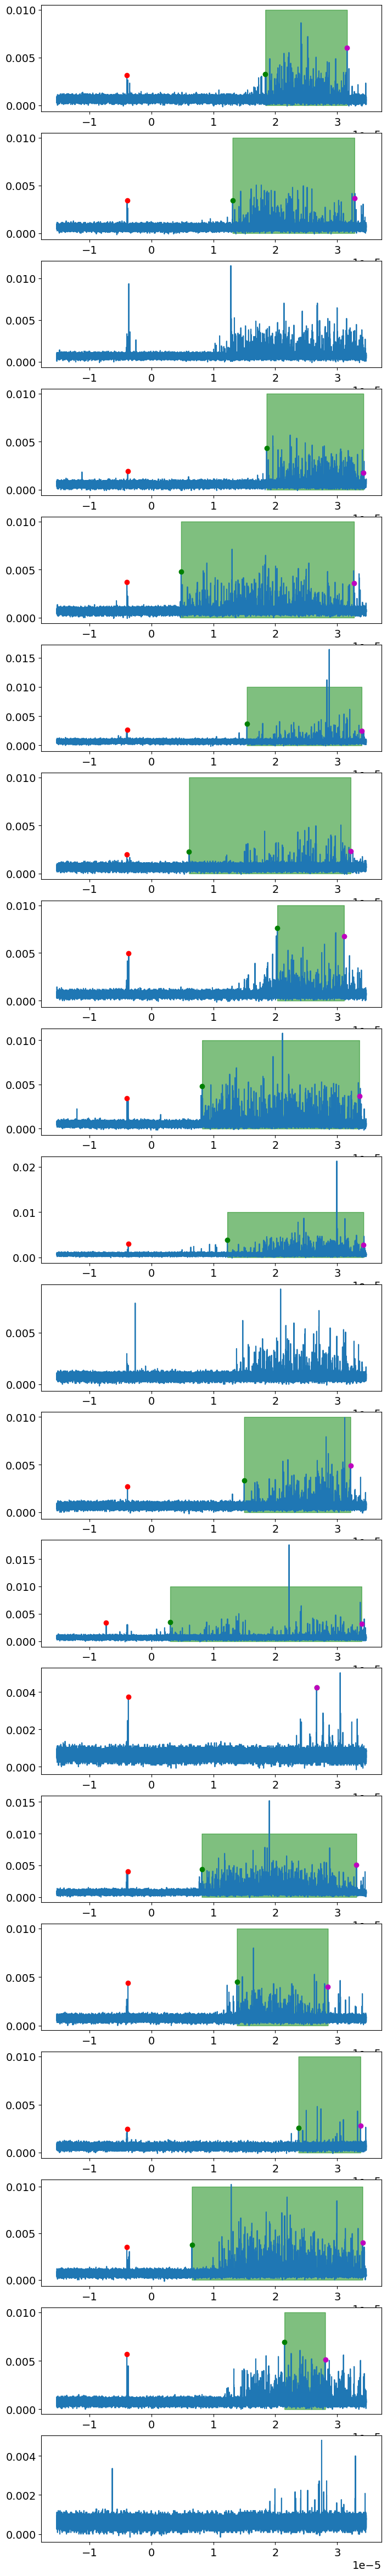

In [282]:
files10 = [sorted(glob(subdirs[0]+pattern))[10*i:10*(i+1)] for i in range(20)]

fig, ax = plt.subplots(len(files10), 1, figsize=(8, 3*len(files10)))
t_drifts = []
t_s1s = []
t_s2s = []
duration_s2s = []
for i,fi in enumerate(files10):
    v_avg, t_avg = compute_average_waveform(fi)
    v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))

    try:
        tdrift, indS1, indS2 = compute_drift_time(t_avg, v_avg)
        dur_s2, indS2_end = compute_s2_duration(t_avg, v_avg, indS1, indS2, frac_s1=0.9, min_distance=50, max_distance=4000)
    except (IndexError, ValueError):
        print(f'No S1 or S2 found in file set {i}')
        continue
    # print(f'Drift time: {tdrift*1e6:.2f} us')
    finally:
        ax[i].plot(t_avg, v_avg)
    

    t_drifts.append(tdrift)
    t_s1s.append(t_avg[indS1] * 1e6)
    t_s2s.append(t_avg[indS2] * 1e6)
    duration_s2s.append(dur_s2)
    ax[i].plot(t_avg[indS1], v_avg[indS1], 'ro')
    ax[i].plot(t_avg[indS2], v_avg[indS2], 'go')
    ax[i].plot(t_avg[indS2_end], v_avg[indS2_end], 'mo')
    # ax[i].fill_between(t_avg[indS2:indS2_end], v_avg[indS2:indS2_end], alpha=0.3, color='gray')
    ax[i].fill_between(t_avg[indS2:indS2_end], 0, 0.01, alpha=0.5, color='green')


[Text(0.5, 0, 'Batch number'), Text(0, 0.5, 'Drift time (us)')]

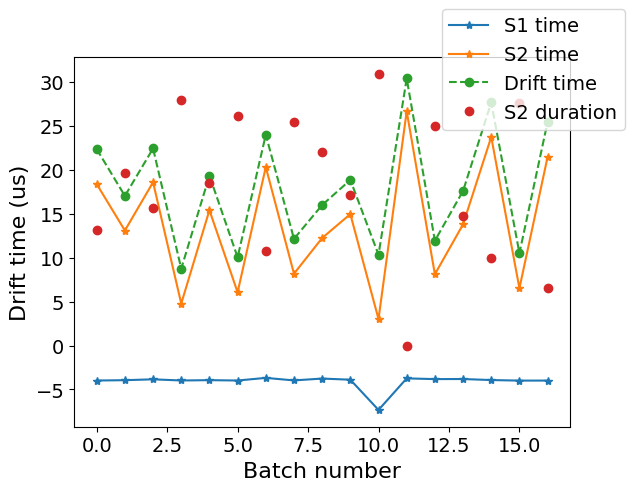

In [283]:
n_batches = np.arange(len(t_drifts))
plt.plot(n_batches, t_s1s, '*-', label='S1 time')
plt.plot(n_batches, t_s2s, '*-', label='S2 time')
plt.plot(n_batches, np.array(t_drifts)*1e6, 'o--', label='Drift time')
plt.plot(n_batches, np.array(duration_s2s)*1e6, 'o', label='S2 duration')
plt.gcf().legend()
plt.gca().set(xlabel='Batch number', ylabel='Drift time (us)',)

## Plot average values for Vgate = 50 V

In [344]:
subdirs[5]

'/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1500_Gate100'

No S1 or S2 found in file set 30
No S1 or S2 found in file set 38
No S1 or S2 found in file set 188
No S1 or S2 found in file set 259


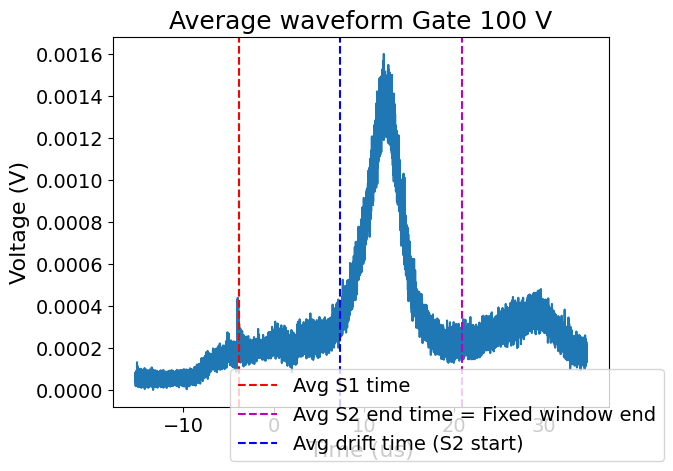

In [352]:
allFiles = sorted(glob(subdirs[5]+pattern))
(tdf_avg, tdf_std), (durS2_avg, durS2_std), s1avg, s2avg = compute_average_drift_time(subdirs[5], batch_size=10, pattern=pattern)
v_avg, t_avg = compute_average_waveform(allFiles)
v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
t_avg = t_avg * 1e6
plt.plot(t_avg, v_avg)
plt.axvline(s1avg, color='r', linestyle='--', label='Avg S1 time')
plt.axvline(s2avg + durS2_avg, color='m', linestyle='--', label='Avg S2 end time = Fixed window end')
plt.axvline(s1avg + tdf_avg, color='b', linestyle='--', label='Avg drift time (S2 start)')
# plt.axvline(s2avg, color='g', linestyle='--', label='Avg S2 time')
plt.gca().set(xlabel='Time (us)', ylabel='Voltage (V)', title='Average waveform Gate 100 V')
plt.gcf().legend(loc='lower right')

## Plot average values for Vgate = 300 V

No S1 or S2 found in file set 108
No S1 or S2 found in file set 283


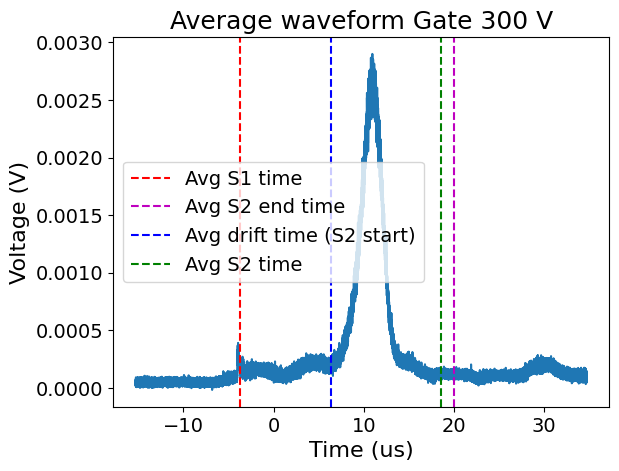

In [353]:
allFiles = sorted(glob(subdirs[9]+pattern))
(tdf_avg, tdf_std), (durV, sdDurV), s1avg, s2avg = compute_average_drift_time(subdirs[9], batch_size=10, pattern=pattern)
v_avg, t_avg = compute_average_waveform(allFiles)
v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
t_avg = t_avg * 1e6
plt.plot(t_avg, v_avg)
plt.axvline(s1avg, color='r', linestyle='--', label='Avg S1 time')
plt.axvline(s2avg + durS2_avg, color='m', linestyle='--', label='Avg S2 end time')
plt.axvline(s1avg + tdf_avg, color='b', linestyle='--', label='Avg drift time (S2 start)')
plt.axvline(s2avg + durV, color='g', linestyle='--', label='Avg S2 time')
plt.gca().set(xlabel='Time (us)', ylabel='Voltage (V)', title='Average waveform Gate 300 V')
plt.legend()

## Plot average values for Vgate = 700 V

No S1 or S2 found in file set 49
No S1 or S2 found in file set 96


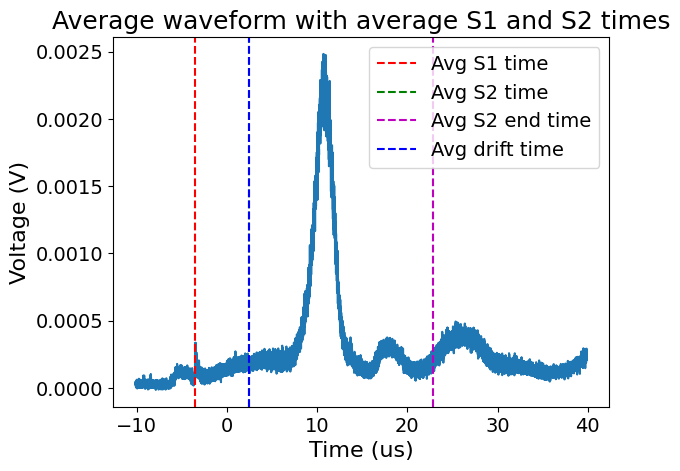

In [336]:
allFiles = sorted(glob(subdirs[13]+pattern))
(tdf_avg, tdf_std), (_, _), s1avg, s2avg = compute_average_drift_time(subdirs[13], batch_size=10, pattern=pattern)
v_avg, t_avg = compute_average_waveform(allFiles)
v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
t_avg = t_avg * 1e6
plt.plot(t_avg, v_avg)
plt.axvline(s1avg, color='r', linestyle='--', label='Avg S1 time')
plt.axvline(s2avg, color='g', linestyle='--', label='Avg S2 time')
plt.axvline(s2avg + durS2_avg, color='m', linestyle='--', label='Avg S2 end time')
plt.axvline(s1avg + tdf_avg, color='b', linestyle='--', label='Avg drift time')
plt.gca().set(xlabel='Time (us)', ylabel='Voltage (V)', title='Average waveform with average S1 and S2 times')
plt.legend()

## Plot average values for Vgate = 1200 V

In [354]:
subdirs[16]

'/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL2600_Gate1200'

No S1 or S2 found in file set 17
No S1 or S2 found in file set 194


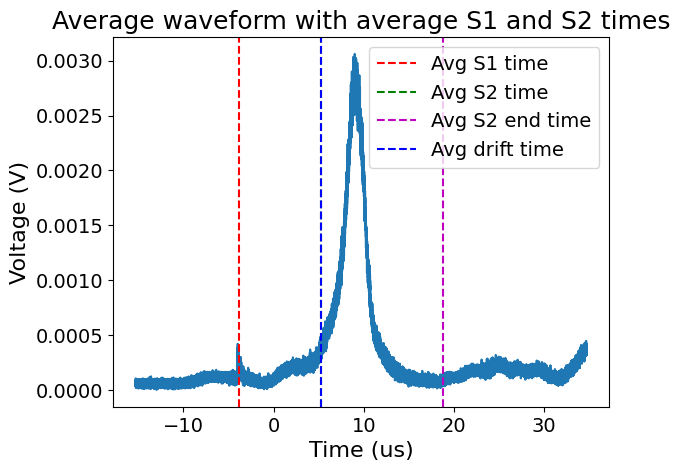

In [355]:
allFiles = sorted(glob(subdirs[16]+pattern))
(tdf_avg, tdf_std), (_, _), s1avg, s2avg = compute_average_drift_time(subdirs[16], batch_size=10, pattern=pattern)
v_avg, t_avg = compute_average_waveform(allFiles)
v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
t_avg = t_avg * 1e6
plt.plot(t_avg, v_avg)
plt.axvline(s1avg, color='r', linestyle='--', label='Avg S1 time')
plt.axvline(s2avg, color='g', linestyle='--', label='Avg S2 time')
plt.axvline(s2avg + durS2_avg, color='m', linestyle='--', label='Avg S2 end time')
plt.axvline(s1avg + tdf_avg, color='b', linestyle='--', label='Avg drift time')
plt.gca().set(xlabel='Time (us)', ylabel='Voltage (V)', title='Average waveform with average S1 and S2 times')
plt.legend()

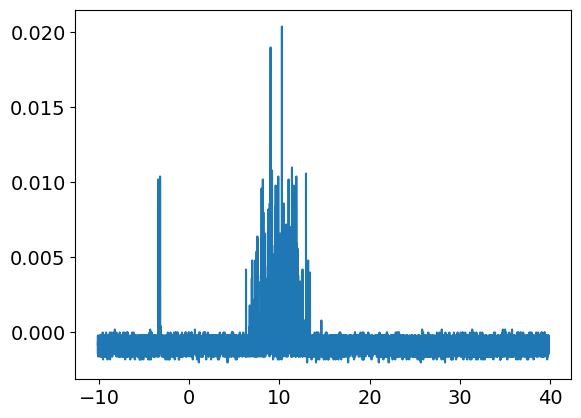

In [331]:
v, t = compute_average_waveform(allFiles[20:24])
plt.plot(t*1e6, v)

# Analysis for all fields

In [231]:
t_drift_avg = []
t_drift_std = []
duration_s2_avg = []
duration_s2_std = []
for subdir in subdirs:
    tdf_avg, tdf_std, durS2_avg, durS2_std = compute_average_drift_time(subdir, batch_size=batch_size, pattern=pattern)
    t_drift_avg.append(tdf_avg)
    t_drift_std.append(tdf_std)
    duration_s2_avg.append(durS2_avg)
    duration_s2_std.append(durS2_std)
    print(f'Subdir: {subdir}, Drift time: {tdf_avg*1e6:.2f} ± {tdf_std*1e6:.2f} us')

No S1 or S2 found in file set 117
Subdir: /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL1450_Gate50, Drift time: 15.07 ± 7.78 us
No S1 or S2 found in file set 51
No S1 or S2 found in file set 119
No S1 or S2 found in file set 128
Subdir: /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL1460_Gate60, Drift time: 12.64 ± 6.58 us
No S1 or S2 found in file set 72
No S1 or S2 found in file set 141
Subdir: /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL1465_Gate65, Drift time: 11.93 ± 5.73 us
No S1 or S2 found in file set 138
Subdir: /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL1470_Gate70, Drift time: 12.01 ± 5.57 us
No S1 or S2 found in file set 21
No S1 or S2 found in file set 32
No S1 or S2 found in file set 42
Subdir: /Users/pabloherrero/sabat/RaTagging/RaTag/scope_d

In [155]:
voltage_pairs = extract_voltage_pairs(base_dir)
E_drifts, E_els = get_fields(voltage_pairs)

[Text(0.5, 0, '$E_{drift}$ (V/cm)'), Text(0, 0.5, 'Drift time (us)')]

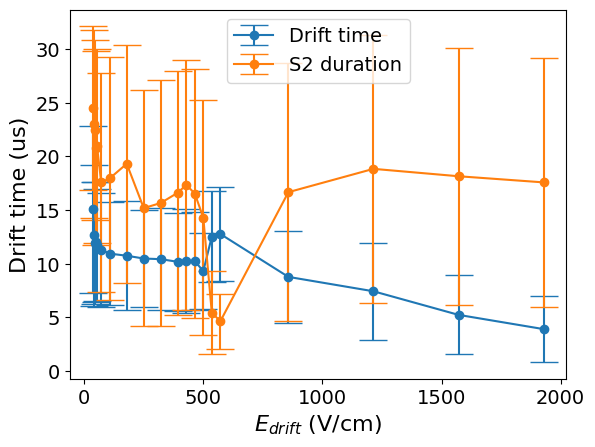

In [238]:
plt.errorbar(E_drifts, np.array(t_drift_avg)*1e6, yerr=np.array(t_drift_std)*1e6, label='Drift time', 
             fmt='o-', capsize=10)
plt.errorbar(E_drifts, np.array(duration_s2_avg)*1e6, yerr=np.array(duration_s2_std)*1e6, label='S2 duration',
             fmt='o-', capsize=10)

plt.legend()
plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Drift time (us)',)
    # xlim=(0, 550))

# Write class to establish S2 integration window
Since we compare many drift fields for the same EL field, the window width (duration) has to be fixed. The start of the window will be modified for each drift field.

The width is established from the maximum S2 window, which is that of the minimum drift field. Then, the class should have a method to find only the start of the S2 and another method to find also the width.

In [ ]:
class S2Window:
    def __init__(self, path_subdir, batch_size=20, pattern='/*.wfm'):
        self.path_subdir = path_subdir
        self.batch_size = batch_size
        self.pattern = pattern
        self.error_count = 0
        
    def batch_files(self):
        n_all_files = len(glob(self.path_subdir+self.pattern))
        files_batch = [sorted(glob(self.path_subdir+self.pattern))[self.batch_size*i:self.batch_size*(i+1)] for i in range(n_all_files//self.batch_size)]
        return files_batch
    
    def compute_average_batch(self, fi):
        v_avg, t_avg = compute_average_waveform(fi)
        v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
        t_avg = t_avg
        return v_avg, t_avg
    
    def find_s1(self, t, V, height_S1=0.001, min_distance=200):
        indS1 = find_peaks(V[t < 0], height=height_S1, distance=min_distance)[0]
        if len(indS1) > 1:
            indS1 = indS1[np.argmax(V[indS1])]
        else:
            indS1 = indS1[0]
        return indS1

    def find_s2_start(self, t, V, indS1, height_frac=0.8, min_distance=50):
        indS2 = find_peaks(V[t > 0], height=V[indS1]*height_frac, distance=min_distance)[0]
        if len(indS2) > 1:
            indS2 = indS2[np.argmin(t[indS2])]
        else:
            indS2 = indS2[0]
        indS2 += len(V[t < 0])
        return indS2

    def find_s2_width(self, t, V, indS1, height_frac=0.8, min_distance=50):
        indS2 = self.find_s2_start(t, V, indS1, height_frac, min_distance)
        indS2_end = find_peaks(V[t > 0], height=V[indS1]*height_frac, distance=min_distance)[0] + len(V[t < 0])
        indS2_end = indS2_end[np.where(np.diff(indS2_end) < 4000)[0]]
        if len(indS2_end) == 0:
            raise ValueError("No valid S2 end found within max distance")
        indS2_end = indS2_end[-1]
        if indS2_end >= len(t):
            raise ValueError("S2 window exceeds waveform length")
        return indS2, indS2_end
    
    def compute_average_s2_window(self):
        
        files_batch = self.batch_files()
        s1_times = []
        s2_starts = []
        s2_ends = []
        
        for fi in files_batch:
            v_avg, t_avg = self.compute_average_batch(fi)
            try:
                indS1 = self.find_s1(t_avg, v_avg)
                indS2, indS2_end = self.find_s2_width(t_avg, v_avg, indS1)
            except (IndexError, ValueError):
                self.error_count += 1
                continue
            s1_times.append(t_avg[indS1])
            s2_starts.append(t_avg[indS2])
            s2_ends.append(t_avg[indS2_end])
        self.s1_avg = np.mean(s1_times)
        self.s2_start_avg = np.mean(s2_starts)
        self.s2_end_avg = np.mean(s2_ends)
        self.duration = self.s2_end_avg - self.s2_start_avg
        return self.s1_avg, self.s2_start_avg, self.s2_end_avg, self.duration
    
    def compute_average_s2_start(self):
        files_batch = self.batch_files()
        s1_times = []
        s2_starts = []
        
        for fi in files_batch:
            v_avg, t_avg = self.compute_average_batch(fi)
            try:
                indS1 = self.find_s1(t_avg, v_avg)
                indS2 = self.find_s2_start(t_avg, v_avg, indS1)
            except (IndexError, ValueError):
                self.error_count += 1
                continue
            s1_times.append(t_avg[indS1])
            s2_starts.append(t_avg[indS2])
        self.s1_avg = np.mean(s1_times)
        self.s2_start_avg = np.mean(s2_starts)
        return self.s1_avg, self.s2_start_avg
    
    def plot_avg_values(self):
        allFiles = sorted(glob(self.path_subdir+self.pattern))
        v_avg, t_avg = compute_average_waveform(allFiles[:self.batch_size])
        v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
        t_avg = t_avg * 1e6
        if not hasattr(self, 's1_avg') or not hasattr(self, 's2_start_avg'):
            raise AttributeError("Average S1 and S2 start times not computed. Run compute_average_s2_start() or compute_average_s2_window() first.")
        plt.plot(t_avg, v_avg)
        plt.axvline(self.s1_avg*1e6, color='r', linestyle='--', label='Avg S1 time')
        plt.axvline(self.s2_start_avg*1e6, color='g', linestyle='--', label='Avg S2 start')
        if hasattr(self, 'duration'):
            plt.axvline(self.s2_start_avg*1e6 + self.duration*1e6, color='m', linestyle='--', label='Avg S2 end time')
        # plt.axvline(self.s1_avg*1e6 + (self.s2_start_avg - self.s1_avg)*1e6, color='b', linestyle='--', label='Avg drift time (S2 start)')
        plt.gca().set(xlabel='Time (us)', ylabel='Voltage (V)', title='Average waveform with average S1 and S2 times')
        plt.legend()

In [369]:
subdirs[5]

'/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN1_EL1750Vcm_1GSsec/FieldScan_1GSsec_EL1500_Gate100'

In [491]:
path50 = subdirs[8]
s2_window_100V = S2Window(path50, batch_size=10)

s1_avg_50V, s2_start_avg_50V, s2_end_avg_50V, width_50V = s2_window_100V.compute_average_s2_window()
s1_avg_50V, s2_start_avg_50V, s2_end_avg_50V, width_50V

No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set


(-4.224530821917807e-06,
 7.487496575342468e-06,
 1.5224414383561648e-05,
 7.73691780821918e-06)

In [414]:
s1_avg_50V, s2_start_avg_50V = s2_window_100V.compute_average_s2_start()
s1_avg_50V, s2_start_avg_50V

No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set


(-4.193730639730638e-06, 7.475973063973067e-06)

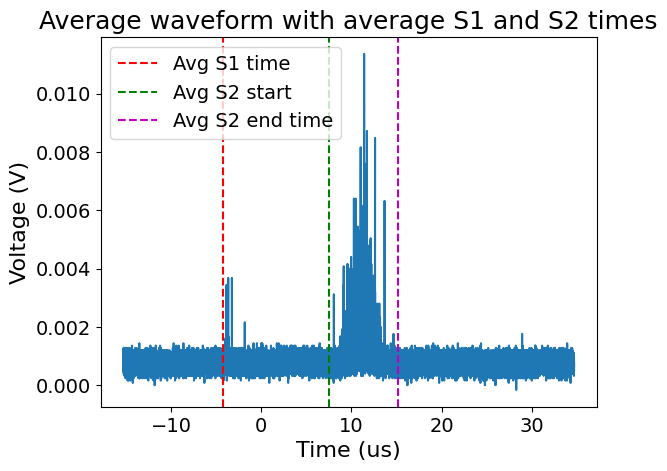

In [417]:
s2_window_100V.plot_avg_values()